In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import warnings
warnings.filterwarnings('ignore')

In [3]:
# df_path = "/home/4cv/project/gc_openPMD-viewer/results/final/middle.csv"
df_path = "/data/gc/rocksdb-index/gc_openPMD-viewer/results/final/small.csv"
df = pd.read_csv(df_path, header=[0])

## Data Pre-processing

In [4]:
print("Before Sampling, each group size:")
print(df.groupby(['target_percentage', 'select_set']).size() / 10)

number_of_each_group = 10
target_percentage = "0.01%"

# Filter DataFrame by target_percentage
df_filtered = df[df['target_percentage'] == target_percentage]

# Group by select_set and get unique envelope values for each group
unique_envelopes = df_filtered.groupby('select_set')['envelope'].unique().reset_index()

# Rename columns for clarity
unique_envelopes.columns = ['select_set', 'unique_envelopes']

# print the number of unique envelopes for each group
# for i in range(number_of_each_group):
#     print(f"Group {i+1} has {len(unique_envelopes['unique_envelopes'][i])} unique envelopes.")

# Function to sample envelopes
# def sample_envelopes(envelopes, n):
#     return list(envelopes.sample(n=min(n, len(envelopes))))

# Apply the sampling to each group
# unique_envelopes['sampled_envelopes'] = unique_envelopes['unique_envelopes'].apply(lambda x: list(pd.Series(x).sample(number_of_each_group)))
# # unique_envelopes['sampled_envelopes'] = unique_envelopes['unique_envelopes'].apply(lambda x: sample_envelopes(pd.Series(x), number_of_each_group))
#
# # Clean up the DataFrame by dropping the original unique envelopes column
# for i in range(number_of_each_group):
#     print(f"Group {i+1} has {len(unique_envelopes['sampled_envelopes'][i])} sampled envelopes.")

unique_envelopes['sampled_envelopes'] = unique_envelopes['unique_envelopes']

# Explode the sampled_envelopes into separate rows
exploded_unique_envelopes = unique_envelopes.explode('sampled_envelopes')

# Merge the exploded_unique_envelopes back to df_filtered to keep only relevant rows
filtered_df = df_filtered.merge(exploded_unique_envelopes[['select_set', 'sampled_envelopes']],
                                left_on=['select_set', 'envelope'],
                                right_on=['select_set', 'sampled_envelopes'])

# Drop the 'sampled_envelopes' column as it's now redundant
filtered_df = filtered_df.drop(columns='sampled_envelopes')

print("")
print(filtered_df.groupby(['target_percentage', 'select_set']).size() / 10)

filtered_df = filtered_df[['select_set', 'test_type', 'query_index_time_elapsed', 'remove_duplication_time_elapsed',
                           'sort_block_metadata_time_elapsed', 'find_optimal_read_solution_time_elapsed',
                           'get_target_data_time_elapsed', 'get_support_data_time_elapsed',
                           'data_calculation_time_elapsed', 'data_apply_select_time_elapsed', 'apply_particle_level_select_array_time_elapsed', 'total_time_elapsed', 'query_result_size', 'chunk_range_size']]

filtered_df['indexing'] = filtered_df['query_index_time_elapsed'] + df['remove_duplication_time_elapsed'] + df['sort_block_metadata_time_elapsed'] + df['find_optimal_read_solution_time_elapsed']
filtered_df['IO_time'] = filtered_df['get_target_data_time_elapsed'] + df['get_support_data_time_elapsed']
filtered_df['calculation'] = filtered_df['data_calculation_time_elapsed'] + df['data_apply_select_time_elapsed'] + df['apply_particle_level_select_array_time_elapsed']

filtered_df = filtered_df[['select_set', 'test_type', 'indexing', 'IO_time', 'calculation', 'total_time_elapsed', 'query_result_size', 'chunk_range_size']]

# Group by select_set and test_type, then compute the average value
averaged_df = filtered_df.groupby(['select_set', 'test_type']).mean().reset_index()


# only keep the select_set with specific values: ('ux',),  ('ux','uy'),  ('ux','uy','uz'),  ('ux','uy','uz','x'), ('ux','uy','uz','x','y'), ('ux','uy','uz','x','y','z')
averaged_df = averaged_df[averaged_df['select_set'].isin(["('ux',)", "('ux','uy')", "('ux','uy','uz')", "('ux','uy','uz','x')", "('ux','uy','uz','x','y')", "('ux','uy','uz','x','y','z')"])]

# a new column to indicate the length of select_set
averaged_df['select_set_length'] = averaged_df['select_set'].apply(lambda x: len(eval(x)))

# sort by select_set_length
averaged_df = averaged_df.sort_values('select_set_length')




Before Sampling, each group size:
target_percentage  select_set                  
0.01%              ('ux','uy')                     15.0
                   ('ux','uy','uz')                15.0
                   ('ux','uy','uz','x')            15.0
                   ('ux','uy','uz','x','y')        15.0
                   ('ux','uy','uz','x','y','z')    15.0
                   ('ux','uy','x','y')             15.0
                   ('ux',)                         15.0
                   ('x','y')                       15.0
                   ('x','y','z')                   15.0
                   ('x',)                          15.0
0.10%              ('ux','uy')                     15.0
                   ('ux','uy','uz')                15.0
                   ('ux','uy','uz','x')            15.0
                   ('ux','uy','uz','x','y')        15.0
                   ('ux','uy','uz','x','y','z')    15.0
                   ('ux','uy','x','y')             15.0
                   ('u

### Overall query time comparison 

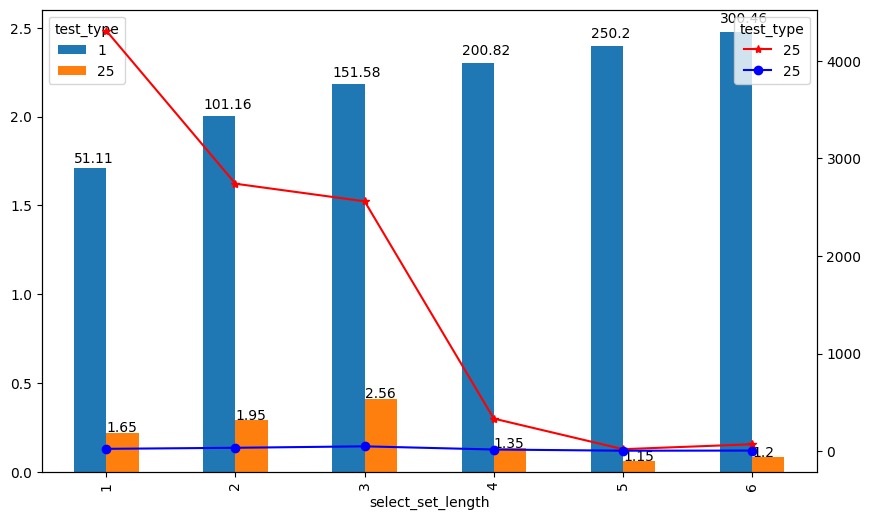

In [10]:
# only keep the test_type with specific values: 1 and 25\
plot_df = averaged_df[averaged_df['test_type'].isin([1, 25])]

fig, ax = plt.subplots()

# set figure size
fig.set_size_inches(10, 6)

# the value difference between test_type 1 and 25 is too large, so we use log scale
plot_df['total_time_elapsed'] = plot_df['total_time_elapsed'].apply(lambda x: np.log10(x+1))

# log for query_result_size and chunk_range_size
# plot_df['query_result_size'] = plot_df['query_result_size'].apply(lambda x: np.log10(x))
# plot_df['chunk_range_size'] = plot_df['chunk_range_size'].apply(lambda x: np.log10(x))


# plot grouped bar chart, x is select_set_length, y is time_elapsed, grouped by test_type
plot_df.pivot(index='select_set_length', columns='test_type', values='total_time_elapsed').plot(kind='bar', ax=ax)

# mark the number on the top of each bar before log
for p in ax.patches:
    ax.annotate(str(round(10**p.get_height(), 2)), (p.get_x() * 1, p.get_height() * 1.02))
    # ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1, p.get_height() * 1.02))
# plot 'query_result_size', 'chunk_range_size' in the same figure as the plot and use right y-axis with test_type = 25
ax2 = ax.twinx()
# ax2.set_xlim((ax.get_xlim()))
# with point * as marker
# select_set_length is the x-axis and start from 0
plot_df['select_set_length'] = plot_df['select_set_length'] - 1
plot_df[averaged_df['test_type'] == 25].pivot(index='select_set_length', columns='test_type', values='query_result_size').plot(kind='line', ax=ax2, color='red', marker='*')
plot_df[averaged_df['test_type'] == 25].pivot(index='select_set_length', columns='test_type', values='chunk_range_size').plot(kind='line', ax=ax2, color='blue', marker='o')


# set the x-axis label to be hrizontal
plt.xticks(rotation=0)
plt.show()

print()

### CPU Calculation Comparison

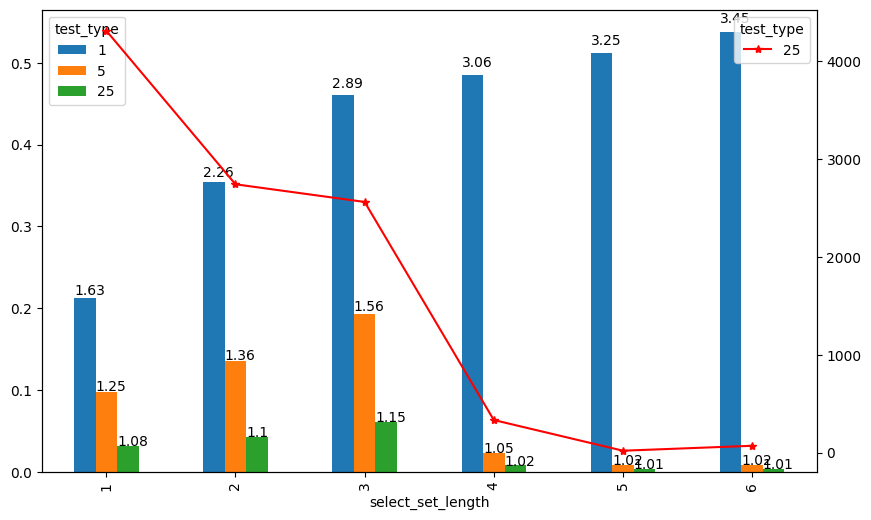

In [11]:
# only keep the test_type with specific values: 5 and 25
plot_df = averaged_df[averaged_df['test_type'].isin([1, 5, 25])]


# the value difference between test_type 1 and 25 is too large, so we use log scale
plot_df['calculation'] = plot_df['calculation'].apply(lambda x: np.log10(x+1))

# log for query_result_size and chunk_range_size
# plot_df['query_result_size'] = plot_df['query_result_size'].apply(lambda x: np.log10(x))
# plot_df['chunk_range_size'] = plot_df['chunk_range_size'].apply(lambda x: np.log10(x))

fig, ax = plt.subplots()

# set figure size
fig.set_size_inches(10, 6)


# plot grouped bar chart, x is select_set_length, y is time_elapsed, grouped by test_type
plot_df.pivot(index='select_set_length', columns='test_type', values='calculation').plot(kind='bar', ax=ax)

# mark the number on the top of each bar before log
for p in ax.patches:
    ax.annotate(str(round(10**p.get_height(), 2)), (p.get_x() * 1, p.get_height() * 1.02))

# plot 'query_result_size', 'chunk_range_size' in the same figure as the plot and use right y-axis with test_type = 25
ax2 = ax.twinx()
# ax2.set_xlim((ax.get_xlim()))
# with point * as marker
# select_set_length is the x-axis and start from 0
plot_df['select_set_length'] = plot_df['select_set_length'] - 1
plot_df[plot_df['test_type'] == 25].pivot(index='select_set_length', columns='test_type', values='query_result_size').plot(kind='line', ax=ax2, color='red', marker='*')
# averaged_df[averaged_df['test_type'] == 25].pivot(index='select_set_length', columns='test_type', values='chunk_range_size').plot(kind='line', ax=ax2, color='blue', marker='o')



# set the x-axis label to be hrizontal
plt.xticks(rotation=0)
plt.show()

print()


### IO Grouping Comparison

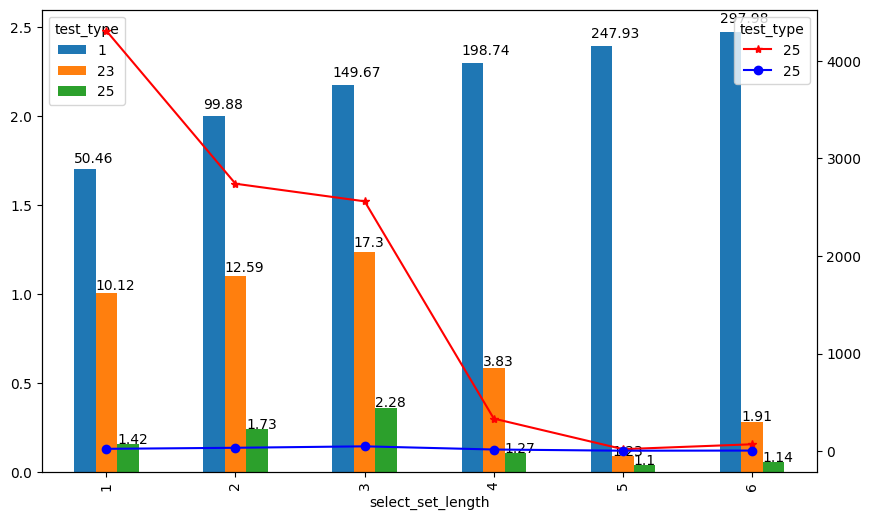

In [12]:
# only keep the test_type with specific values: 5 and 25
plot_df = averaged_df[averaged_df['test_type'].isin([1, 23, 25])]


# the value difference between test_type 1 and 25 is too large, so we use log scale
plot_df['IO_time'] = plot_df['IO_time'].apply(lambda x: np.log10(x+1))

# log for query_result_size and chunk_range_size
# plot_df['query_result_size'] = plot_df['query_result_size'].apply(lambda x: np.log10(x))
# plot_df['chunk_range_size'] = plot_df['chunk_range_size'].apply(lambda x: np.log10(x))

fig, ax = plt.subplots()

# set figure size
fig.set_size_inches(10, 6)


# plot grouped bar chart, x is select_set_length, y is time_elapsed, grouped by test_type
plot_df.pivot(index='select_set_length', columns='test_type', values='IO_time').plot(kind='bar', ax=ax)

# mark the number on the top of each bar before log
for p in ax.patches:
    ax.annotate(str(round(10**p.get_height(), 2)), (p.get_x() * 1, p.get_height() * 1.02))
    # ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1, p.get_height() * 1.02))
# plot 'query_result_size', 'chunk_range_size' in the same figure as the plot and use right y-axis with test_type = 25
ax2 = ax.twinx()
# ax2.set_xlim((ax.get_xlim()))
# with point * as marker
# select_set_length is the x-axis and start from 0
plot_df['select_set_length'] = plot_df['select_set_length'] - 1
plot_df[averaged_df['test_type'] == 25].pivot(index='select_set_length', columns='test_type', values='query_result_size').plot(kind='line', ax=ax2, color='red', marker='*')
plot_df[averaged_df['test_type'] == 25].pivot(index='select_set_length', columns='test_type', values='chunk_range_size').plot(kind='line', ax=ax2, color='blue', marker='o')



# set the x-axis label to be hrizontal
plt.xticks(rotation=0)
plt.show()

print()

# IO cost proportion comparison

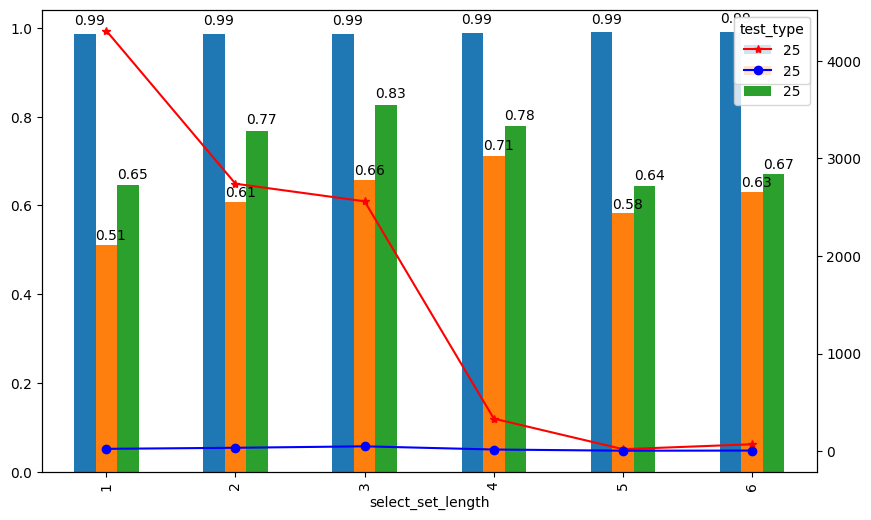

In [13]:
# only keep the test_type with specific values: 5 and 25
plot_df = averaged_df[averaged_df['test_type'].isin([1, 5, 25])]


plot_df['IO_Percent'] = plot_df['IO_time'] / plot_df['total_time_elapsed']

# the value difference between test_type 1 and 25 is too large, so we use log scale
# averaged_df['IO_time'] = averaged_df['IO_time'].apply(lambda x: np.log10(x+1))

# log for query_result_size and chunk_range_size
# plot_df['query_result_size'] = plot_df['query_result_size'].apply(lambda x: np.log10(x))
# plot_df['chunk_range_size'] = plot_df['chunk_range_size'].apply(lambda x: np.log10(x))

fig, ax = plt.subplots()

# set figure size
fig.set_size_inches(10, 6)


# plot grouped bar chart, x is select_set_length, y is time_elapsed, grouped by test_type
plot_df.pivot(index='select_set_length', columns='test_type', values='IO_Percent').plot(kind='bar', ax=ax)

# mark the number on the top of each bar before log
for p in ax.patches:
    # ax.annotate(str(round(10**p.get_height(), 2)), (p.get_x() * 1, p.get_height() * 1.02))
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1, p.get_height() * 1.02))
# plot 'query_result_size', 'chunk_range_size' in the same figure as the plot and use right y-axis with test_type = 25
ax2 = ax.twinx()
# ax2.set_xlim((ax.get_xlim()))
# with point * as marker
# select_set_length is the x-axis and start from 0
plot_df['select_set_length'] = plot_df['select_set_length'] - 1
plot_df[plot_df['test_type'] == 25].pivot(index='select_set_length', columns='test_type', values='query_result_size').plot(kind='line', ax=ax2, color='red', marker='*')
plot_df[plot_df['test_type'] == 25].pivot(index='select_set_length', columns='test_type', values='chunk_range_size').plot(kind='line', ax=ax2, color='blue', marker='o')



# set the x-axis label to be hrizontal
plt.xticks(rotation=0)
plt.show()

print()

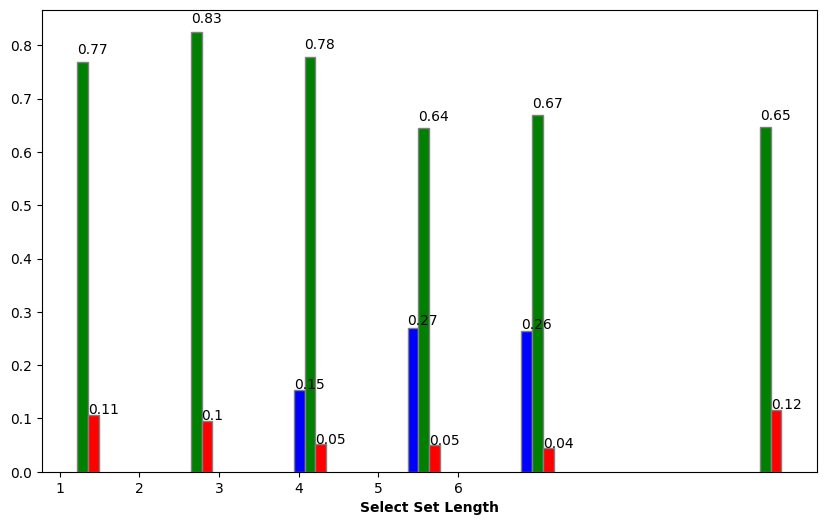

In [9]:
# only keep the test_type with specific values: 5 and 25
plot_df = averaged_df[averaged_df['test_type'].isin([25])]

plot_df['indexing_Percent'] = plot_df['indexing'] / plot_df['total_time_elapsed']
plot_df['IO_Percent'] = plot_df['IO_time'] / plot_df['total_time_elapsed']
plot_df['calculation_Percent'] = plot_df['calculation'] / plot_df['total_time_elapsed']



fig, ax = plt.subplots()

# set figure size
fig.set_size_inches(10, 6)


# plot grouped bar chart, x is select_set_length, plot the percentage of each part in total time_elapsed
# Define bar width
bar_width = 0.95

# Set positions of the bars on the x-axis
r1 = plot_df.index
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bars
ax.bar(r1, plot_df['indexing_Percent'], color='b', width=bar_width, edgecolor='grey', label='Indexing')
ax.bar(r2, plot_df['IO_Percent'], color='g', width=bar_width, edgecolor='grey', label='I/O')
ax.bar(r3, plot_df['calculation_Percent'], color='r', width=bar_width, edgecolor='grey', label='Calculation')


# Add xticks on the middle of the group bars
ax.set_xlabel('Select Set Length', fontweight='bold')
ax.set_xticks([r*7 + bar_width + 7 for r in range(len(plot_df))])
ax.set_xticklabels(plot_df['select_set_length'])

# mark the number on the top of each bar before log
for p in ax.patches:
    # ax.annotate(str(round(10**p.get_height(), 2)), (p.get_x() * 1, p.get_height() * 1.02))
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1, p.get_height() * 1.02))
                

# set the x-axis label to be hrizontal
plt.xticks(rotation=0)
plt.show()

print()